In [1]:
import math
import numpy as np
import pickle

from matplotlib import pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
from matplotlib.backends.backend_pdf import PdfPages

import dipper


In [2]:
dippers_data = pickle.load(open('dippers_data_v1.pkl', 'rb'))

In [3]:
gold_dippers = dippers_data[dippers_data['sample']=='A']

In [4]:
silver_dippers = dippers_data[dippers_data['sample']=='B']
silver_dippers.reset_index(inplace=True)

In [5]:
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines):

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    return c1, c2

In [6]:
def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    c1, c2 = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=3, loc1b=4, loc2b=4,
        prop_lines=kwargs)

    return c1, c2




In [7]:
def make_page():
    fig = plt.figure(figsize=[8.5, 11])
    main_height = 0.1
    full_height = 0.1
    main_width = 0.4
    first_col_start = 0.1
    
    ax_list_full_lc = []
    ax_list_zoom = []
    
    #left column
    ax_list_zoom.append(fig.add_axes([first_col_start, 3*0.025+0.05+2*0.1+3*full_height+2*main_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([first_col_start, 2*0.025+0.05+2*0.1+2*full_height+2*main_height, main_width, full_height ]))

    ax_list_zoom.append(fig.add_axes([first_col_start, 0.025+0.05+full_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([first_col_start, 0.05, main_width, full_height]))
    
    ax_list_zoom.append(fig.add_axes([first_col_start, 2*0.025+0.05+0.1+2*full_height+main_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([first_col_start, 0.025+0.05+0.1+full_height+main_height, main_width, full_height ]))
    
    
    #right column
    ax_list_zoom.append(fig.add_axes([0.55, 3*0.025+0.05+2*0.1+3*full_height+2*main_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([0.55, 2*0.025+0.05+2*0.1+2*full_height+2*main_height, main_width, full_height ]))
    
    ax_list_zoom.append(fig.add_axes([0.55, 2*0.025+0.05+0.1+2*full_height+main_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([0.55, 0.025+0.05+0.1+full_height+main_height, main_width, full_height ]))
    
    ax_list_zoom.append(fig.add_axes([0.55, 0.025+0.05+full_height, main_width, main_height]))
    ax_list_full_lc.append(fig.add_axes([0.55,  0.05, main_width, full_height]))

    return fig, ax_list_full_lc, ax_list_zoom

## Gold Sample

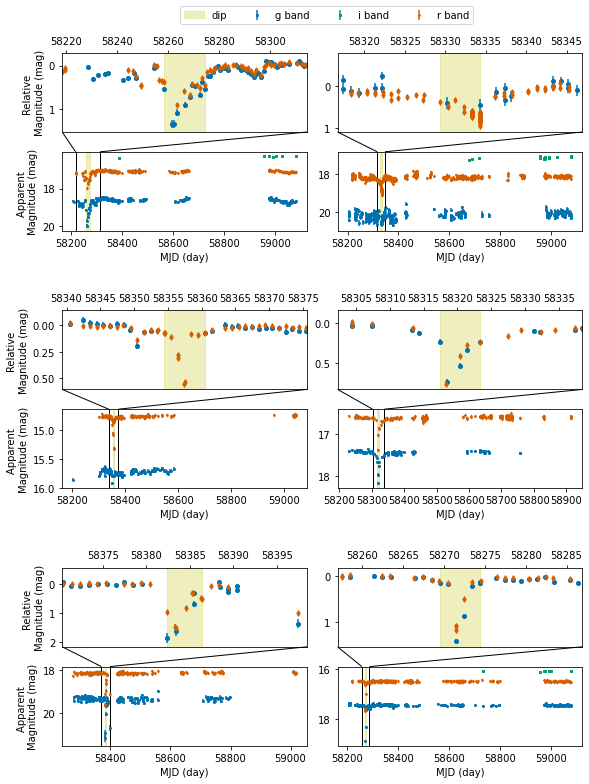

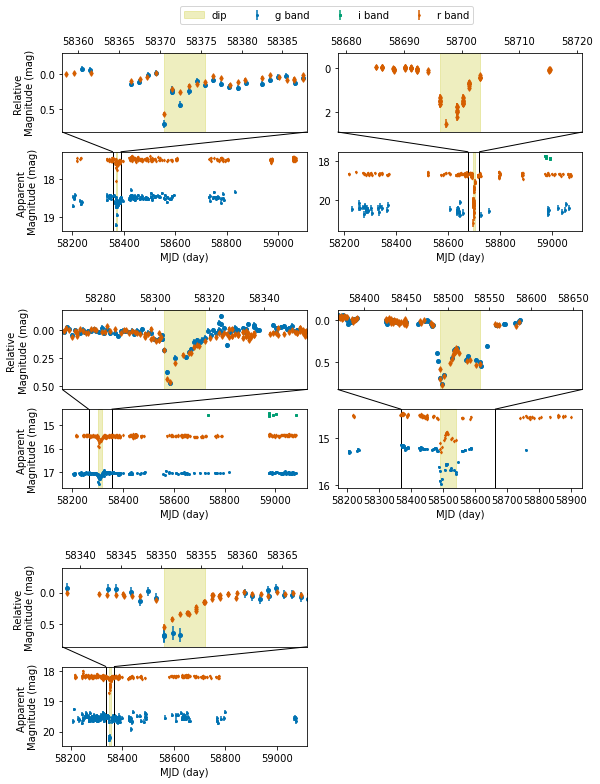

In [8]:
marker_dict = {'g':'o', 'r':'d', 'i':'s'}
plt.style.use('seaborn-colorblind')
fig1, ax_list_full_lc1, ax_list_zoom1 = make_page()
fig2, ax_list_full_lc2, ax_list_zoom2 = make_page()
ax_list_full_lc = ax_list_full_lc1 + ax_list_full_lc2
ax_list_zoom = ax_list_zoom1 + ax_list_zoom2
with PdfPages('gold_sample_light_curves.pdf') as pdf:
    for ax_indx, idipper in gold_dippers.iterrows():
        #Color dip region in full LC plot
        ax_list_full_lc[ax_indx].axvspan(idipper['dip_dip_start_mjd'], idipper['dip_dip_end_mjd'], 
                                         color='y', alpha=0.25, label='dip')
        for band in ['g', 'i', 'r']:
            #reject all bad observations
            mjd, mag, magerr = dipper.filter_ztf_observations(
                idipper[f'mjd_{band}'],
                idipper[f'mag_{band}'],
                idipper[f'magerr_{band}'],
                idipper[f'xpos_{band}'],
                idipper[f'ypos_{band}'],
                idipper[f'catflags_{band}'])
            #Plot full light curves
            ax_list_full_lc[ax_indx].errorbar(mjd, mag, magerr, fmt=marker_dict[band], markersize=2, label=f'{band} band')
            #mask out all observations in the window and do the reference level subtraction
            mjd, mag, magerr, ref_scale = dipper.parse_light_curve(
                mjd, mag, magerr, (idipper['dip_window_start_mjd'], idipper['dip_window_end_mjd']),
                min_observations=1)
            #Plot zoomed light curves
            ax_list_zoom[ax_indx].errorbar(mjd, mag, magerr, fmt=marker_dict[band], markersize=4, label=f'{band} band')


        ax_list_full_lc[ax_indx].invert_yaxis()
        ax_list_zoom[ax_indx].invert_yaxis()

        #Set x range of zoom based on dip size
        window_padding = 0.5*(idipper['dip_window_end_mjd']-idipper['dip_window_start_mjd'])
        xmin_zoom  = idipper['dip_window_start_mjd']-window_padding 
        xmax_zoom = idipper['dip_window_end_mjd']+window_padding
        #Plot zoom range in full LC plot
        ax_list_full_lc[ax_indx].axvline(xmin_zoom, color='k', lw=1)
        ax_list_full_lc[ax_indx].axvline(xmax_zoom, color='k', lw=1)
        #ax_list_zoom[ax_indx].axvline(idipper['dip_window_start_mjd'], color='k', lw=0.5, ls=':')
        #ax_list_zoom[ax_indx].axvline(idipper['dip_window_end_mjd'], color='k', lw=0.5, ls=':')

        #Zoom in on region
        ax_list_zoom[ax_indx].set_xlim(xmin_zoom, xmax_zoom )
        #ax_list_zoom[ax_indx].axvline(idipper['dip_initial_window_start_mjd'], color='k')
        #ax_list_zoom[ax_indx].axvline(idipper['dip_initial_window_end_mjd'], color='k')

        #Move ticks and labels for x axis of zoom plot to top
        ax_list_zoom[ax_indx].xaxis.set_label_position('top')
        ax_list_zoom[ax_indx].xaxis.set_ticks_position('top')

        if ax_indx%6==0:
            ax_list_full_lc[ax_indx].legend( bbox_to_anchor=[1.5, 2.7, 0.2, 0.2], ncol=4)
        ax_list_full_lc[ax_indx].set_xlabel('MJD (day)')
        if ax_indx%6 <= 2:
            ax_list_full_lc[ax_indx].set_ylabel('Apparent \nMagnitude (mag)')
            ax_list_zoom[ax_indx].set_ylabel('Relative \nMagnitude (mag)')

        ax_list_zoom[ax_indx].axvspan(idipper['dip_dip_start_mjd'], idipper['dip_dip_end_mjd'], color='y', alpha=0.25)


        c1, c2 = zoom_effect02(ax_list_zoom[ax_indx], ax_list_full_lc[ax_indx])
        ax_list_full_lc[ax_indx].add_patch(c1)
        ax_list_full_lc[ax_indx].add_patch(c2)

    while ax_indx < len(ax_list_zoom)-1:
        ax_indx += 1
        ax_list_zoom[ax_indx].set_visible(False)
        ax_list_full_lc[ax_indx].set_visible(False)
    pdf.savefig(fig1)
    pdf.savefig(fig2)

## Silver Sample

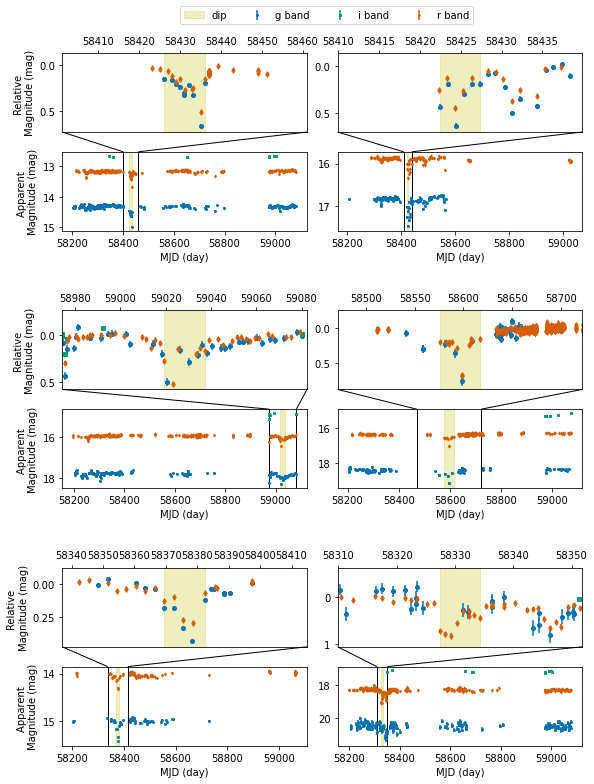

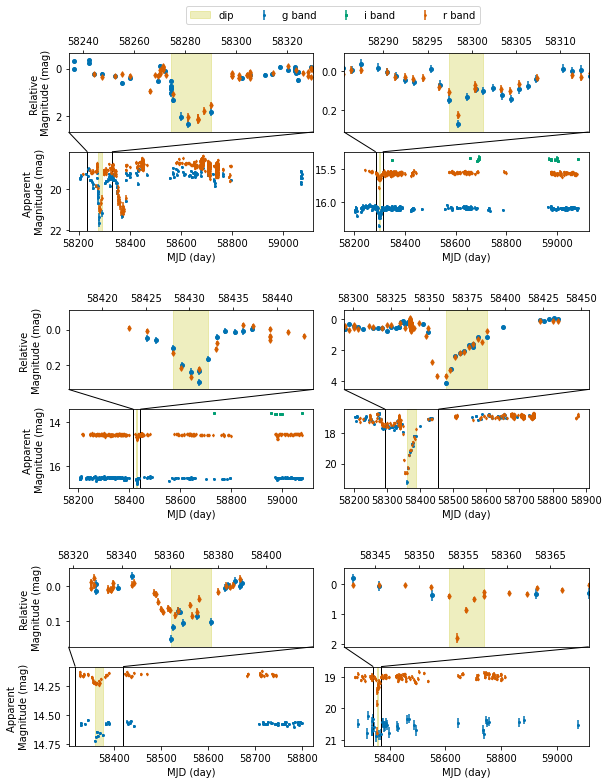

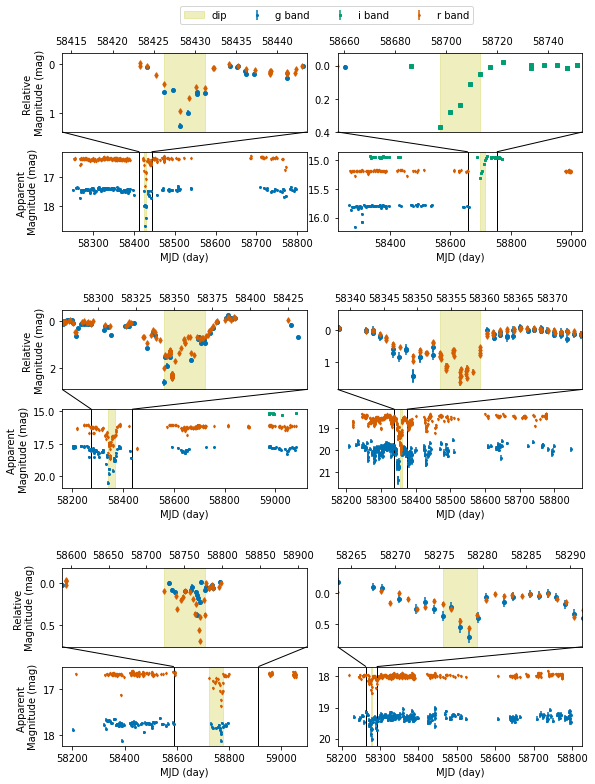

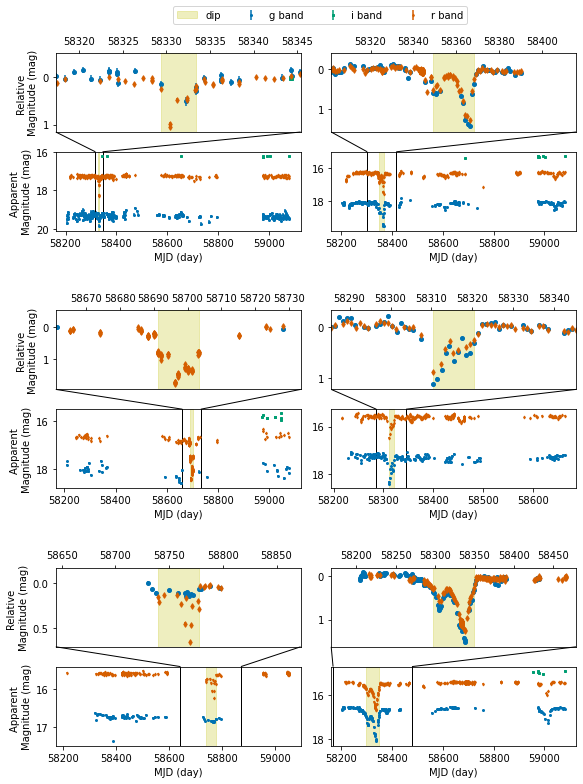

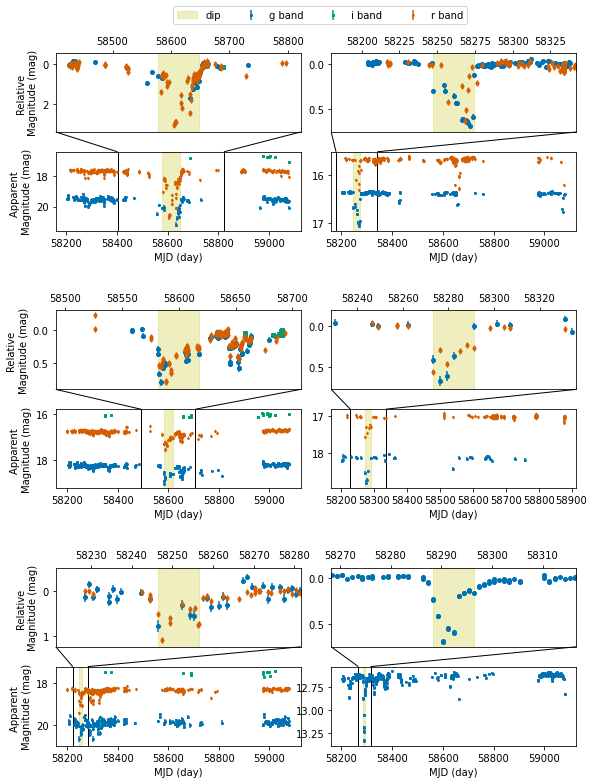

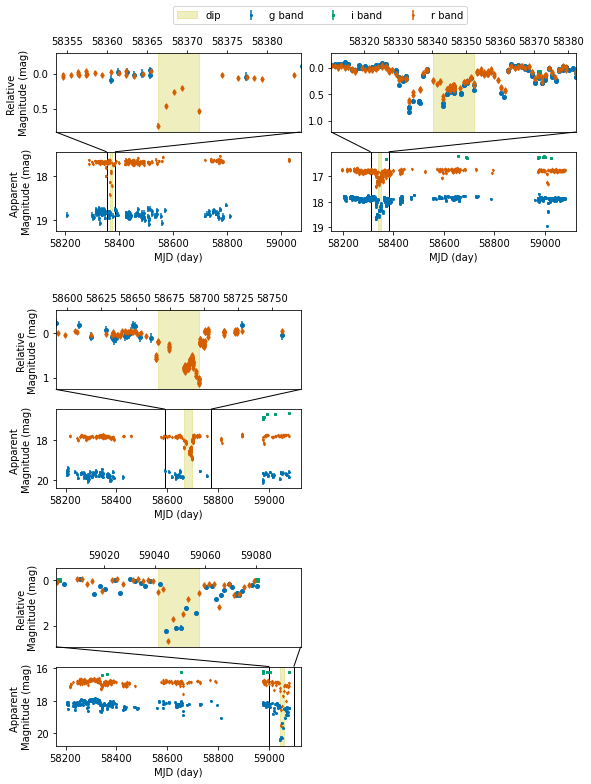

In [9]:
marker_dict = {'g':'o', 'r':'d', 'i':'s'}
plt.style.use('seaborn-colorblind')
fig_list = []
ax_list_full_lc = []
ax_list_zoom = []
for i in range(math.ceil(len(silver_dippers)/6.)):
    fig, ax_full, ax_zoom = make_page()
    fig_list.append(fig)
    ax_list_full_lc+=ax_full
    ax_list_zoom+=ax_zoom
with PdfPages('silver_sample_light_curves.pdf') as pdf:
    for ax_indx, idipper in silver_dippers.iterrows():
        #Color dip region in full LC plot
        ax_list_full_lc[ax_indx].axvspan(idipper['dip_dip_start_mjd'], idipper['dip_dip_end_mjd'], 
                                         color='y', alpha=0.25, label='dip')
        for band in ['g', 'i', 'r']:
            #reject all bad observations
            mjd, mag, magerr = dipper.filter_ztf_observations(
                idipper[f'mjd_{band}'],
                idipper[f'mag_{band}'],
                idipper[f'magerr_{band}'],
                idipper[f'xpos_{band}'],
                idipper[f'ypos_{band}'],
                idipper[f'catflags_{band}'])
            #Plot full light curves
            ax_list_full_lc[ax_indx].errorbar(mjd, mag, magerr, fmt=marker_dict[band], markersize=2, label=f'{band} band')
            #mask out all observations in the window and do the reference level subtraction
            mjd, mag, magerr, ref_scale = dipper.parse_light_curve(
                mjd, mag, magerr, (idipper['dip_window_start_mjd'], idipper['dip_window_end_mjd']),
                min_observations=1)
            #Plot zoomed light curves
            ax_list_zoom[ax_indx].errorbar(mjd, mag, magerr, fmt=marker_dict[band], markersize=4, label=f'{band} band')


        ax_list_full_lc[ax_indx].invert_yaxis()
        ax_list_zoom[ax_indx].invert_yaxis()

        #Set x range of zoom based on dip size
        window_padding = 0.5*(idipper['dip_window_end_mjd']-idipper['dip_window_start_mjd'])
        xmin_zoom  = idipper['dip_window_start_mjd']-window_padding 
        xmax_zoom = idipper['dip_window_end_mjd']+window_padding
        #Plot zoom range in full LC plot
        ax_list_full_lc[ax_indx].axvline(xmin_zoom, color='k', lw=1)
        ax_list_full_lc[ax_indx].axvline(xmax_zoom, color='k', lw=1)
        #ax_list_zoom[ax_indx].axvline(idipper['dip_window_start_mjd'], color='k', lw=0.5, ls=':')
        #ax_list_zoom[ax_indx].axvline(idipper['dip_window_end_mjd'], color='k', lw=0.5, ls=':')

        #Zoom in on region
        ax_list_zoom[ax_indx].set_xlim(xmin_zoom, xmax_zoom )
        #ax_list_zoom[ax_indx].axvline(idipper['dip_initial_window_start_mjd'], color='k')
        #ax_list_zoom[ax_indx].axvline(idipper['dip_initial_window_end_mjd'], color='k')

        #Move ticks and labels for x axis of zoom plot to top
        ax_list_zoom[ax_indx].xaxis.set_label_position('top')
        ax_list_zoom[ax_indx].xaxis.set_ticks_position('top')

        if ax_indx%6==0:
            ax_list_full_lc[ax_indx].legend( bbox_to_anchor=[1.5, 2.7, 0.2, 0.2], ncol=4)
        ax_list_full_lc[ax_indx].set_xlabel('MJD (day)')
        if ax_indx%6 <= 2:
            ax_list_full_lc[ax_indx].set_ylabel('Apparent \nMagnitude (mag)')
            ax_list_zoom[ax_indx].set_ylabel('Relative \nMagnitude (mag)')

        ax_list_zoom[ax_indx].axvspan(idipper['dip_dip_start_mjd'], idipper['dip_dip_end_mjd'], color='y', alpha=0.25)


        c1, c2 = zoom_effect02(ax_list_zoom[ax_indx], ax_list_full_lc[ax_indx])
        ax_list_full_lc[ax_indx].add_patch(c1)
        ax_list_full_lc[ax_indx].add_patch(c2)

    while ax_indx < len(ax_list_zoom)-1:
        ax_indx += 1
        ax_list_zoom[ax_indx].set_visible(False)
        ax_list_full_lc[ax_indx].set_visible(False)
    for fig in fig_list:
        pdf.savefig(fig)